<a href="https://colab.research.google.com/github/Minhvt34/On-Neural-Stochastic-Differential-Equation/blob/main/NSDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffrax
!pip install optax
!pip install equinox

In [ ]:
import jax.numpy as jnp
import jax.random as jrandom
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, PIDController
import equinox as eqx
import optax

import time
from typing import Union
import matplotlib.pyplot as plt

#import wandb

In [ ]:
class MPLOne(eqx.Module):

  network: eqx.Module
  idx: Union[None, int]

  def __init__(self, network, idx=None):
    self.network = network
    self.idx = idx

  def __call__(self, t, x, *args):
    if self.idx == None:
      return self.network(x)
    else:
      return jnp.hstack((x[self.idx], self.network(x)))

In [ ]:
class NeuralODE(eqx.Module):

  func: eqx.Module

  def __init__(self, func):
    self.func = func

  def __call__(self, ts, y0, *args):
    # Integrate ODE
    sol = diffeqsolve(
      ODETerm(self.func),
      Tsit5(),
      t0=ts[0],
      t1=ts[-1],
      dt0=ts[1] - ts[0],
      y0=y0,
      args=args,
      stepsize_controller=PIDController(rtol=1e-3, atol=1e-6),
      saveat=SaveAt(ts=ts),
    )

    return sol.ys


In [ ]:
def main(
    ts,
    y_pred,
    learning_rate = 1e-3,
    epochs=10000,
    width_size=128,
    depth=1,
    seed = 42
  ):

  # run = wandb.init(project='NeuralODE',
  #                    entity="minhvt-34",
  #                    reinit=True,
  #                    settings=wandb.Settings(start_method="fork"))

  # Neural network
  key = jrandom.PRNGKey(seed)

  mlp = eqx.nn.MLP(
      in_size = 2,
      out_size = 1,
      width_size = width_size,
      depth = depth,
      key = key
  )

  network = MPLOne(network = mlp, idx = 1)
  model = NeuralODE(network)

  # loss
  @eqx.filter_value_and_grad
  def grad_loss(model, ti, yi):
    y_pred = model(ti, yi[0, :])
    print(f"true label: {yi[0, :]}")
    return jnp.mean((yi - y_pred)**2)

  optim = optax.adabelief(learning_rate)

  # Iterator
  @eqx.filter_jit
  def make_step(ti, yi, model, opt_state):

    # Evaluate loss and gradient
    loss, grads = grad_loss(model, ti, yi)

    # Update state based on gradient
    updates, opt_state = optim.update(grads, opt_state)

    # Update parameters in model
    model = eqx.apply_updates(model, updates)

    # Return loss, updated model and state
    return loss, model, opt_state


  # Parameter state initialization
  opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

  # Optimizer interations
  losses = jnp.zeros(epochs)

  for (i, step) in enumerate(range(epochs)):

    start = time.time()

    loss, model, opt_state = make_step(ts, y_pred, model, opt_state)

    end = time.time()

    losses = losses.at[i].set(loss)

    print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    # wandb.log(
    #       {
    #         "Step": step,
    #         "train loss": loss,
    #         "computation time": end - start,
    #       }
    #     )


  return model, losses

In [ ]:
ys = jnp.load("sol_ys.npy")
nn_ys = jnp.load("nn_sol.npy")

In [ ]:



ts = jnp.linspace(0, 10, 200)
model, losses = main(ts, ys, epochs=10000)

Streaming output truncated to the last 5000 lines.
Step: 5000, Loss: 0.0004281117580831051, Computation time: 0.04950118064880371
Step: 5001, Loss: 0.00043245896813459694, Computation time: 0.05056333541870117
Step: 5002, Loss: 0.00045731410500593483, Computation time: 0.05378007888793945
Step: 5003, Loss: 0.00044291006634011865, Computation time: 0.052109718322753906
Step: 5004, Loss: 0.00043851349619217217, Computation time: 0.05471992492675781
Step: 5005, Loss: 0.0004340011510066688, Computation time: 0.049601078033447266
Step: 5006, Loss: 0.000433239561971277, Computation time: 0.04895639419555664
Step: 5007, Loss: 0.0004504700191318989, Computation time: 0.05140566825866699
Step: 5008, Loss: 0.0004515524487942457, Computation time: 0.050913095474243164
Step: 5009, Loss: 0.00043235908378846943, Computation time: 0.05096602439880371
Step: 5010, Loss: 0.0004469218838494271, Computation time: 0.0490412712097168
Step: 5011, Loss: 0.00043165343231521547, Computation time: 0.054916381835

In [ ]:
import jax

def lipswish(x):
  return 0.909*jax.nn.silu(x)

In [ ]:
class ControlledVectorField(eqx.Module):

  scale: Union[int, jnp.ndarray]
  mlp: eqx.nn.MLP
  control_size: int
  hidden_size: int

  def __init__(self, control_size, hidden_size, width_size, depth, scale, *, key, **kwargs):
    super().__init__(**kwargs)
    scale_key, mlp_key = jrandom.split(key)

    if scale:
      self.scale = jrandom.uniform(
          scale_key, (hidden_size, control_size), minval=0.9, maxval=1.1
      )
    else:
      self.scale = 1

    self.mlp = eqx.nn.MLP(
        in_size=hidden_size + 1,
        out_size=hidden_size*control_size,
        width_size=width_size,
        depth=depth,
        activation=lipswish,
        final_activation=jax.nn.tanh,
        key=mlp_key,
    )

    self.control_size = control_size
    self.hidden_size = hidden_size

  def __call__(self, t, x, args):
    return self.scale * self.mlp(jnp.concatenate((t[None], x))).reshape(
        self.hidden_size, self.control_size
    )

In [ ]:
import diffrax

In [ ]:
class ControlledVectorField(eqx.Module):

  scale: Union[int, jnp.ndarray]
  mlp: eqx.nn.MLP
  control_size: int
  hidden_size: int

  def __init__(self, control_size, hidden_size, width_size, depth, scale, *, key, **kwargs):
    super().__init__(**kwargs)
    scale_key, mlp_key = jrandom.split(key)

    if scale:
      self.scale = jrandom.uniform(
          scale_key, (hidden_size, control_size), minval=-1.0, maxval=1.0
      )
    else:
      self.scale = 1

    self.mlp = eqx.nn.MLP(
        in_size=hidden_size+1,
        out_size=hidden_size*control_size,
        width_size=width_size,
        depth=depth,
        activation=lipswish,
        final_activation=jax.nn.tanh,
        key=mlp_key,
    )

    self.control_size = control_size
    self.hidden_size = hidden_size


  def __call__(self, t, x, args):

    return self.scale * self.mlp(jnp.concatenate([t[None], x])).reshape(
            self.hidden_size, self.control_size
        )

In [ ]:
class NeuralDiffusion(eqx.Module):
  initial: eqx.nn.MLP
  # drift - pre-trained model
  cvf: ControlledVectorField  # diffusion
  readout: eqx.nn.Linear
  initial_noise_size: int
  noise_size: int

  def __init__(self,
               data_size,
               initial_noise_size,
               noise_size,
               hidden_size,
               width_size,
               depth,
               *,
               key,
               **kwargs):
    super().__init__(**kwargs)

    initial_key, vf_key, cvf_key, readout_key = jrandom.split(key, 4)

    self.initial = eqx.nn.MLP(initial_noise_size,
                              hidden_size,
                              width_size,
                              depth,
                              key=initial_key
                              )
    #self.vf = VectorField(hidden_size, width_size, depth, scale=True, key=vf_key)
    self.cvf = ControlledVectorField(noise_size, hidden_size, width_size, depth, scale=True, key=cvf_key)
    self.readout = eqx.nn.Linear(hidden_size, data_size, key=readout_key)

    self.initial_noise_size = initial_noise_size
    self.noise_size = noise_size

  def __call__(self, ts, *, key):
    t0 = ts[0]
    t1 = ts[-1]

    # Very large dt0 for computational speed
    dt0 = 0.1
    init_key, bm_key = jrandom.split(key, 2)
    init = jrandom.normal(init_key, (self.initial_noise_size,))
    control = diffrax.VirtualBrownianTree(
        t0=t0, t1=t1, tol=dt0/2, shape=(self.noise_size,), key=bm_key
    )

    y0 = self.initial(init)

    #vf = diffrax.ODETerm(self.vf)                      # Drift term
    diffusion_term = diffrax.ControlTerm(self.cvf, control) # Diffusion term
    #terms = diffrax.MultiTerm(vf, cvf)

    # Reversible Heun is a cheap choice of SDE solver. We could also use Euler etc.
    solver = diffrax.ReversibleHeun()

    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffusion_term,
        solver,
        t0=t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        saveat=saveat,
    )

    print(f"y0 value: {y0} --- {sol.ys.shape}")

    return jax.vmap(self.readout)(sol.ys)

In [ ]:
class NeuralSDE(eqx.Module):
  drift_term: eqx.Module             # drift
  diffusion_term: eqx.Module   # diffusion

  def __init__(self,
               data_size,
               initial_input_size,
               noise_size,
               hidden_size,
               width_size,
               depth,
               drift_model,
               *,
               key,
               **kwargs):
    super().__init__(**kwargs)

    vf_key, cvf_key = jrandom.split(key, 2)


    self.drift_term = drift_model
    self.diffusion_term = NeuralDiffusion(data_size, initial_input_size, noise_size, hidden_size, width_size, depth, key=cvf_key)

  def __call__(self, ts, y0, *, key):

    return self.drift_term(ts, y0) + self.diffusion_term(ts, key=key)

In [ ]:
initial_input_size=2
noise_size=3
hidden_size=16
width_size=128
depth=1
generator_lr=2e-5
discriminator_lr=1e-4
batch_size=16
steps=10000
steps_per_print=200
data_size=2
seed=42

In [ ]:
drift_model = model

In [ ]:
key = jrandom.PRNGKey(seed)
(
    data_key,
    generator_key,
    discriminator_key,
    dataloader_key,
    train_key,
    evaluate_key,
    sample_key,
) = jrandom.split(key, 7)
data_key = jrandom.split(data_key, data_size)

#_, _, data_size = ys.shape

sde_model = NeuralSDE(
    data_size,
    initial_input_size,
    noise_size,
    hidden_size,
    width_size,
    depth,
    drift_model,
    key=generator_key,
)

In [ ]:
optim = optax.adabelief(discriminator_lr)

In [ ]:
# loss
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi, key):
  y_pred = model(ti, yi[0, :], key=key)

  return jnp.mean((yi - y_pred)**2)



# Iterator
@eqx.filter_jit
def make_step(ti, yi, model, opt_state, optim, key):

  # Evaluate loss and gradient
  loss, grads = grad_loss(model, ti, yi, key)

  # Update state based on gradient
  updates, opt_state = optim.update(grads, opt_state)

  # Update parameters in model
  model = eqx.apply_updates(model, updates)

  # Return loss, updated model and state
  return loss, model, opt_state


y0 value: Traced<ShapedArray(float32[16])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[16])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[16])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[16]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ea2141b3dd0>, in_tracers=(Traced<ShapedArray(float32[16]):JaxprTrace(level=2/0)>,), out_tracer_refs=[<weakref at 0x7ea2103eca40; to 'JaxprTracer' at 0x7ea2103ecb30>], out_avals=[ShapedArray(float32[16])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[16]. let  in (a,) }, 'in_shardings': (UnspecifiedValue,), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False,), 'name': 'swapaxes', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7ea2103f04b0>, name_stack=NameStack(stack=(Transform(name='jvp'), Scope(name='eqx.nn.MLP'))))) --- (200, 16)
Step: 0, Lo

Text(0.5, 1.0, 'Loss vs Epochs')

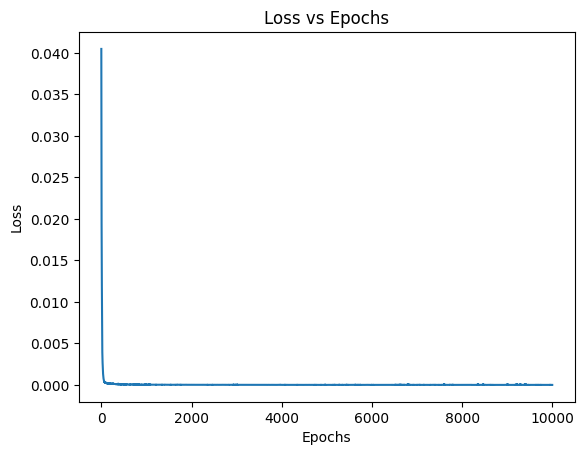

In [ ]:
# Parameter state initialization
opt_state = optim.init(eqx.filter(sde_model, eqx.is_inexact_array))

training_key = jrandom.PRNGKey(42)

# Optimizer interations
losses = jnp.zeros(steps)

for (i, step) in enumerate(range(steps)):

  start = time.time()

  loss, sde_model, opt_state = make_step(ts, ys, sde_model, opt_state, optim, training_key)

  end = time.time()

  losses = losses.at[i].set(loss)

  if (step % steps_per_print) == 0 or step == steps - 1:
    print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

# Using Noise dim = 2, optim = adabelief
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")



In [ ]:
# Define ODE
def nonlinear_pendulum(t, y, args):
  theta, omega = y
  mu, g, l = args
  d_theta = omega
  d_omega = -(mu*omega + g/l*jnp.sin(theta))
  d_y = jnp.array((d_theta, d_omega))

  return d_y

In [ ]:
# ODE specification
dt0 = 0.1
l = 1.0
g = 9.81
mu = 0.3
args = (mu, g, l)

In [ ]:
num_samples = 100

test_key = jrandom.split(sample_key, num_samples)

In [ ]:
ts_test = jnp.linspace(0, 10, 200)

In [ ]:
num_sol = diffeqsolve(
  ODETerm(nonlinear_pendulum),
  Tsit5(),
  t0=ts_test[0],
  t1=ts_test[-1],
  dt0=dt0,
  y0=ys[0, :],
  args=args,
  saveat=SaveAt(ts=ts_test)
)

In [ ]:
nn_sol = drift_model(ts_test, ys[0, :])

In [ ]:
ys_sampled = []
for key in test_key:
  pred = sde_model(ts_test, ys[0, :], key=key)
  ys_sampled.append(pred)

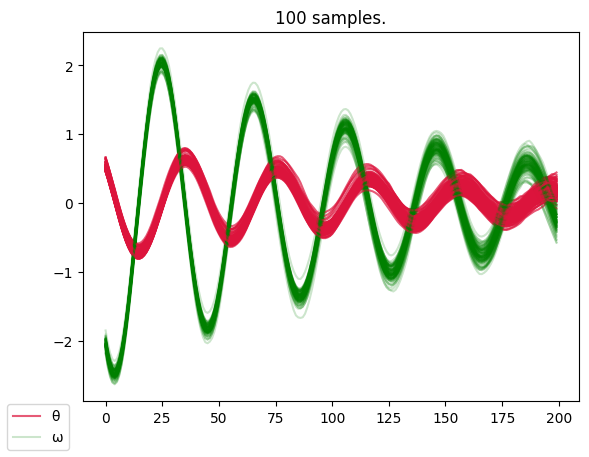

In [ ]:
# ts_Test = [0, 10, 200]
fig, ax = plt.subplots()

for yi in ys_sampled:
  ax.plot(yi[:, 0], c="crimson", alpha=0.7)
  ax.plot(yi[:, 1], c="green", alpha=0.2)

ax.set_title(f"{num_samples} samples.")
fig.legend(["θ", "ω"], loc="lower left")
#fig.tight_layout()

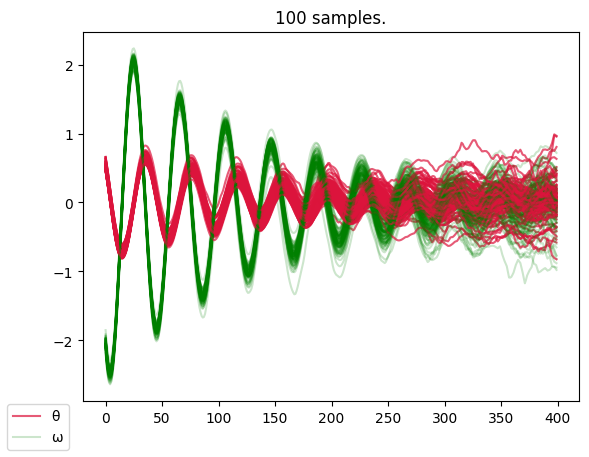

In [ ]:
# ts_Test = [0, 20, 400]
fig, ax = plt.subplots()

for yi in ys_sampled:
  ax.plot(yi[:, 0], c="crimson", alpha=0.7)
  ax.plot(yi[:, 1], c="green", alpha=0.2)

ax.set_title(f"{num_samples} samples.")
fig.legend(["θ", "ω"], loc="lower left")
#fig.tight_layout()

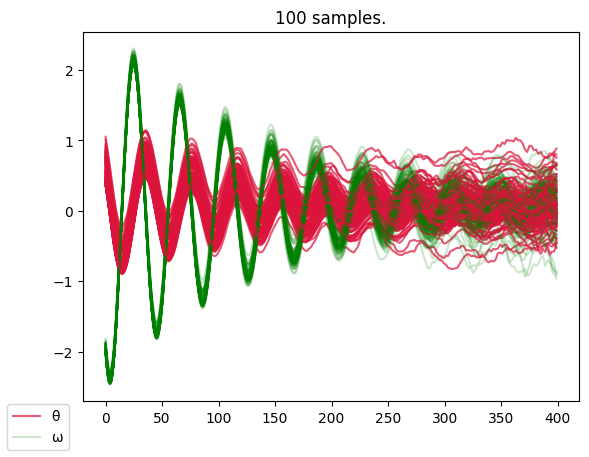

In [ ]:
# ts_Test = [0, 20, 400]

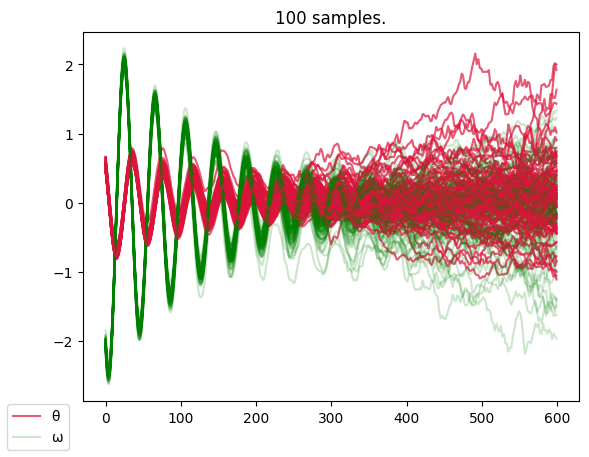

In [ ]:
# ts_Test = [0, 30, 600]
fig, ax = plt.subplots()

for yi in ys_sampled:
  ax.plot(yi[:, 0], c="crimson", alpha=0.7)
  ax.plot(yi[:, 1], c="green", alpha=0.2)

ax.set_title(f"{num_samples} samples.")
fig.legend(["θ", "ω"], loc="lower left")
#fig.tight_layout()

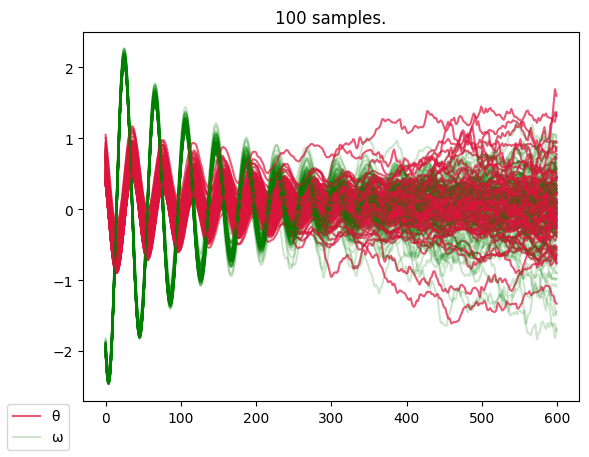

In [ ]:
# ts_Test = [0, 30, 600]

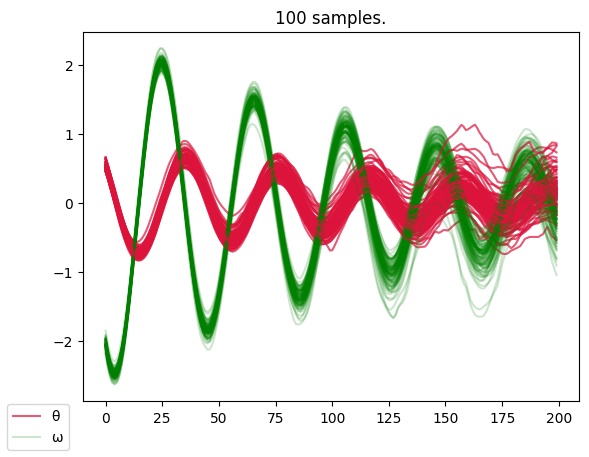

In [ ]:
# ts_Test = [10, 20, 200]
fig, ax = plt.subplots()

for yi in ys_sampled:
  ax.plot(yi[:, 0], c="crimson", alpha=0.7)
  ax.plot(yi[:, 1], c="green", alpha=0.2)

ax.set_title(f"{num_samples} samples.")
fig.legend(["θ", "ω"], loc="lower left")
#fig.tight_layout()

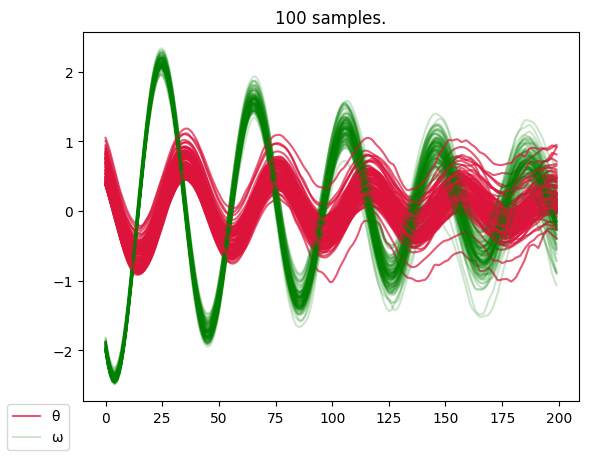

In [ ]:
# ts_Test = [10, 20, 200]

In [ ]:
ys_stack = jnp.stack(ys_sampled)

In [ ]:
mean_pred = jnp.mean(ys_stack, axis=0)
std_pred = jnp.std(ys_stack, axis=0)

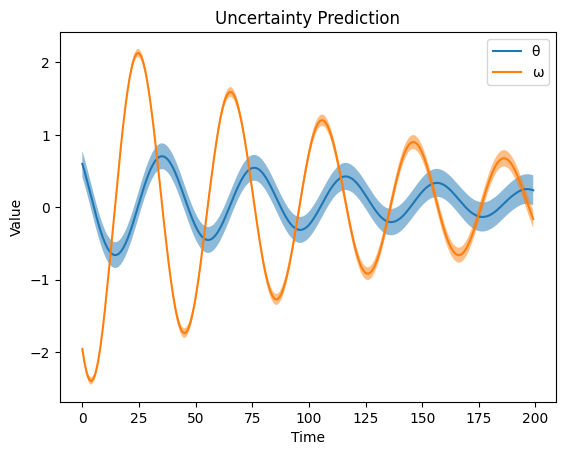

In [ ]:
# Optim = adabelief - width dim = 128 hidden dim = 16 - applied clip weight - noise ratio 5
plt.title("Uncertainty Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.plot(mean_pred[:, 0], label="θ")
plt.fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)

plt.plot(mean_pred[:, 1], label="ω")
plt.fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)

plt.legend()

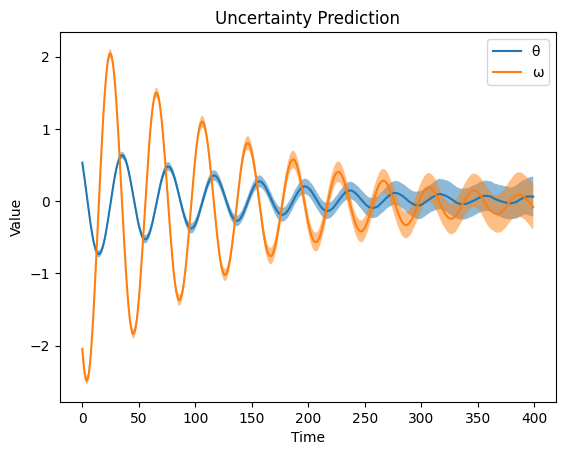

In [ ]:
# Optim = adabelief - width dim = 128 hidden dim = 16 - applied clip weight - noise ratio 5
plt.title("Uncertainty Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.plot(mean_pred[:, 0], label="θ")
plt.fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)

plt.plot(mean_pred[:, 1], label="ω")
plt.fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)

plt.legend()

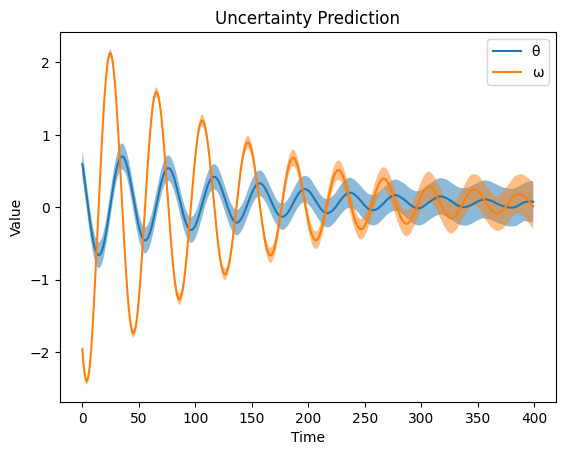

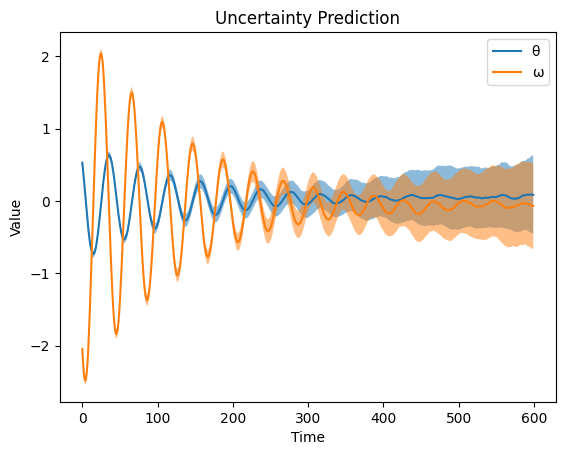

In [ ]:
# Optim = adabelief - width dim = 128 hidden dim = 16 - applied clip weight - noise ratio 5
plt.title("Uncertainty Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.plot(mean_pred[:, 0], label="θ")
plt.fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)

plt.plot(mean_pred[:, 1], label="ω")
plt.fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)

plt.legend()

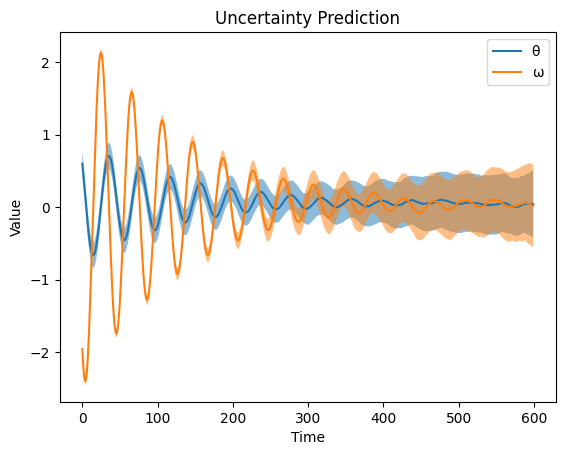

In [ ]:
# Optim = adabelief - width dim = 128 hidden dim = 16 - applied clip weight - noise ratio 5

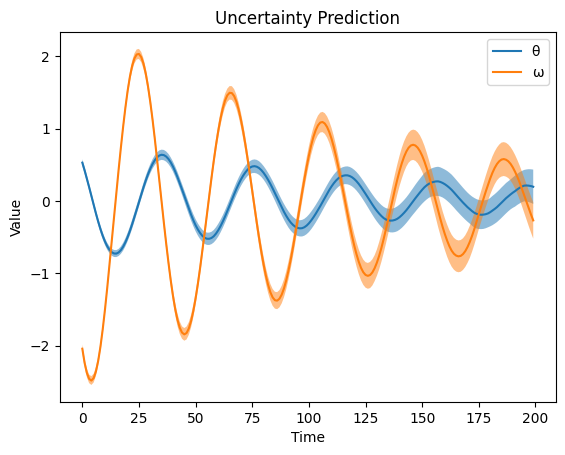

In [ ]:
# Optim = adabelief - width dim = 128 hidden dim = 16 - applied clip weight - noise ratio 5
plt.title("Uncertainty Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.plot(mean_pred[:, 0], label="θ")
plt.fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)

plt.plot(mean_pred[:, 1], label="ω")
plt.fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)

plt.legend()

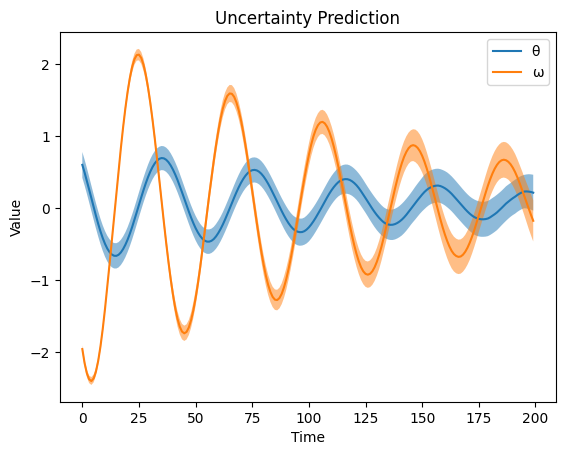

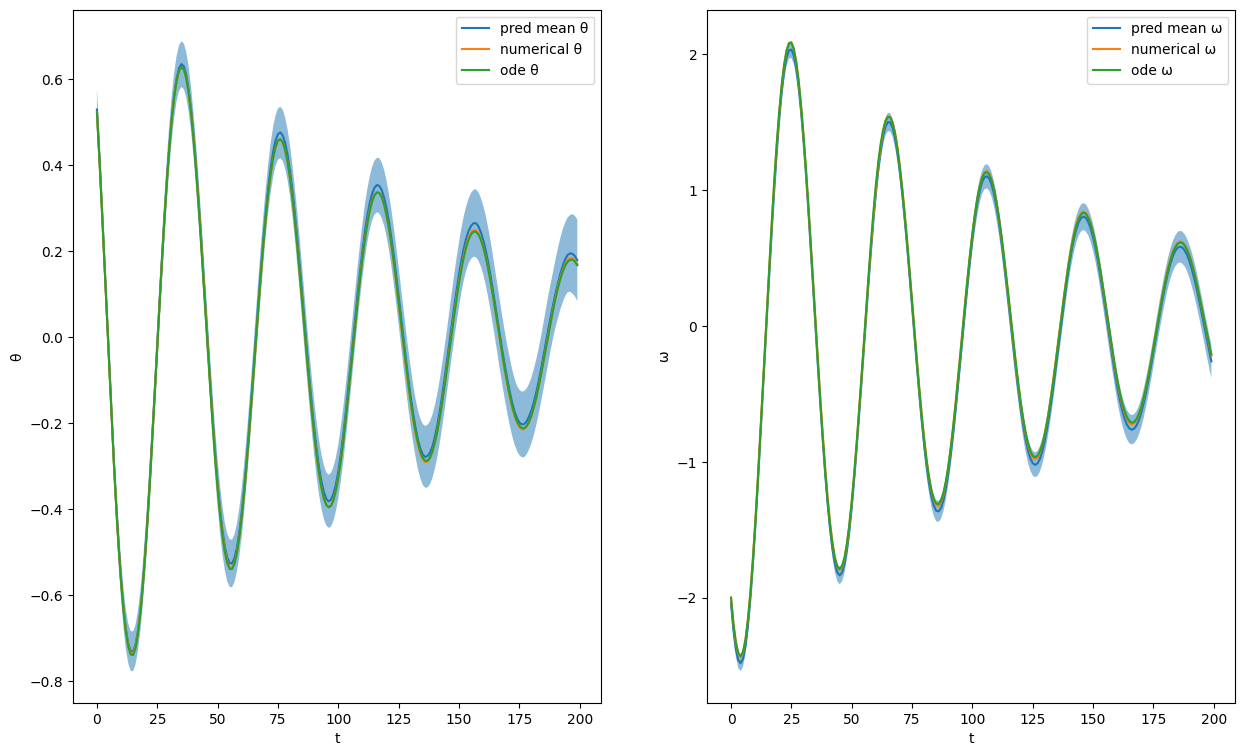

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
ax[0].set_xlabel("time")
ax[0].plot(mean_pred[:, 0], label="pred mean θ")
ax[0].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)
ax[0].plot(ys[:, 0], label="numerical θ")
ax[0].plot(nn_ys[:, 0], label="ode θ")


ax[0].set_xlabel("t")
ax[0].set_ylabel("θ")
ax[0].legend()

# (ω,t)
ax[1].plot(mean_pred[:, 1], label="pred mean ω")
ax[1].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)
ax[1].plot(ys[:, 1], label="numerical ω")
ax[1].plot(nn_ys[:, 1], label="ode ω")


ax[1].set_xlabel("t")
ax[1].set_ylabel("ω")
ax[1].legend()

$𝚫$

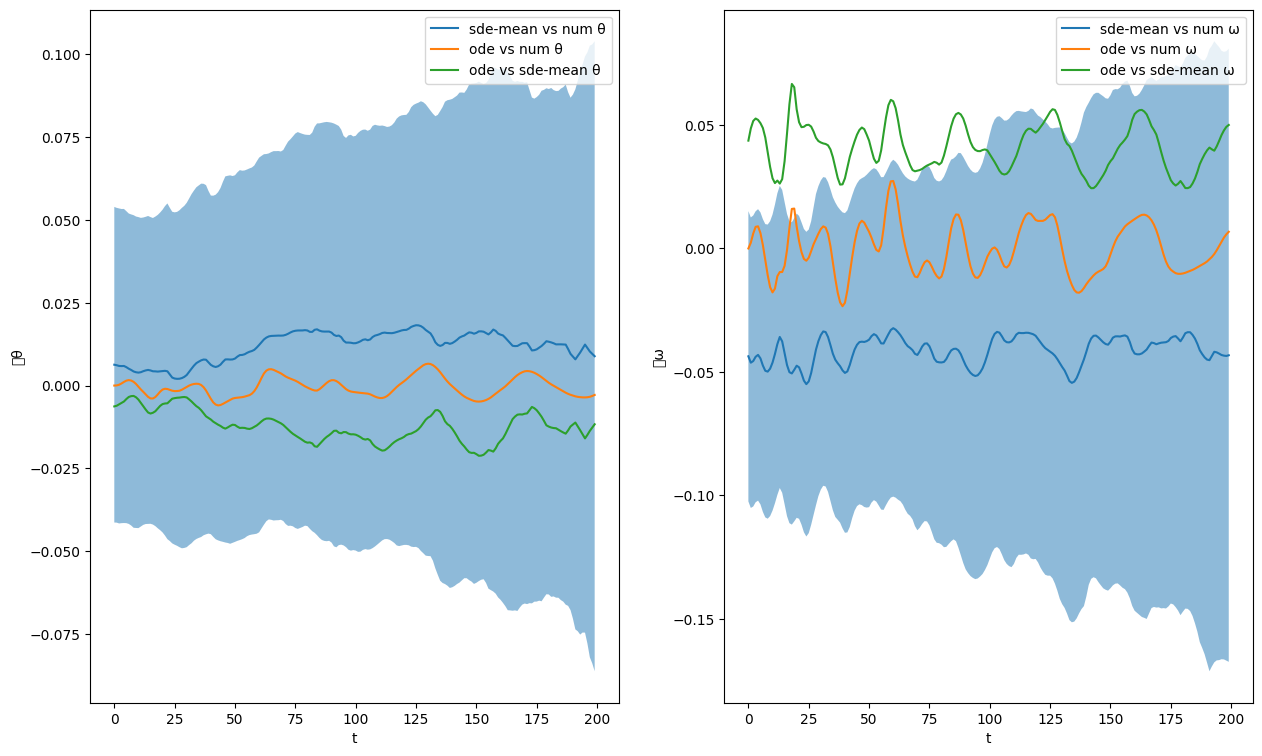

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
theta_res = mean_pred[:, 0] - ys[:, 0]
ode_theta_res = nn_ys[:, 0] - ys[:, 0]
ode_theta_mean = nn_ys[:, 0] - mean_pred[:, 0]

ax[0].set_xlabel("time")
ax[0].plot(theta_res, label="sde-mean vs num θ")
ax[0].plot(ode_theta_res, label="ode vs num θ")
ax[0].plot(ode_theta_mean, label="ode vs sde-mean θ")

ax[0].fill_between(jnp.arange(len(mean_pred)), theta_res - std_pred[:, 0], theta_res + std_pred[:, 0], alpha=0.5)

ax[0].set_xlabel("t")
ax[0].set_ylabel("𝚫θ")
ax[0].legend()

# (ω,t)

omega_res = mean_pred[:, 1] - ys[:, 1]
ode_omega_res = nn_ys[:, 1] - ys[:, 1]
ode_omega_mean = nn_ys[:, 1] - mean_pred[:, 1]

ax[1].plot(omega_res, label="sde-mean vs num ω")
ax[1].plot(ode_omega_res, label="ode vs num ω")
ax[1].plot(ode_omega_mean, label="ode vs sde-mean ω")

ax[1].fill_between(jnp.arange(len(mean_pred)), omega_res - std_pred[:, 1], omega_res + std_pred[:, 1], alpha=0.5)

ax[1].set_xlabel("t")
ax[1].set_ylabel("𝚫ω")
ax[1].legend()

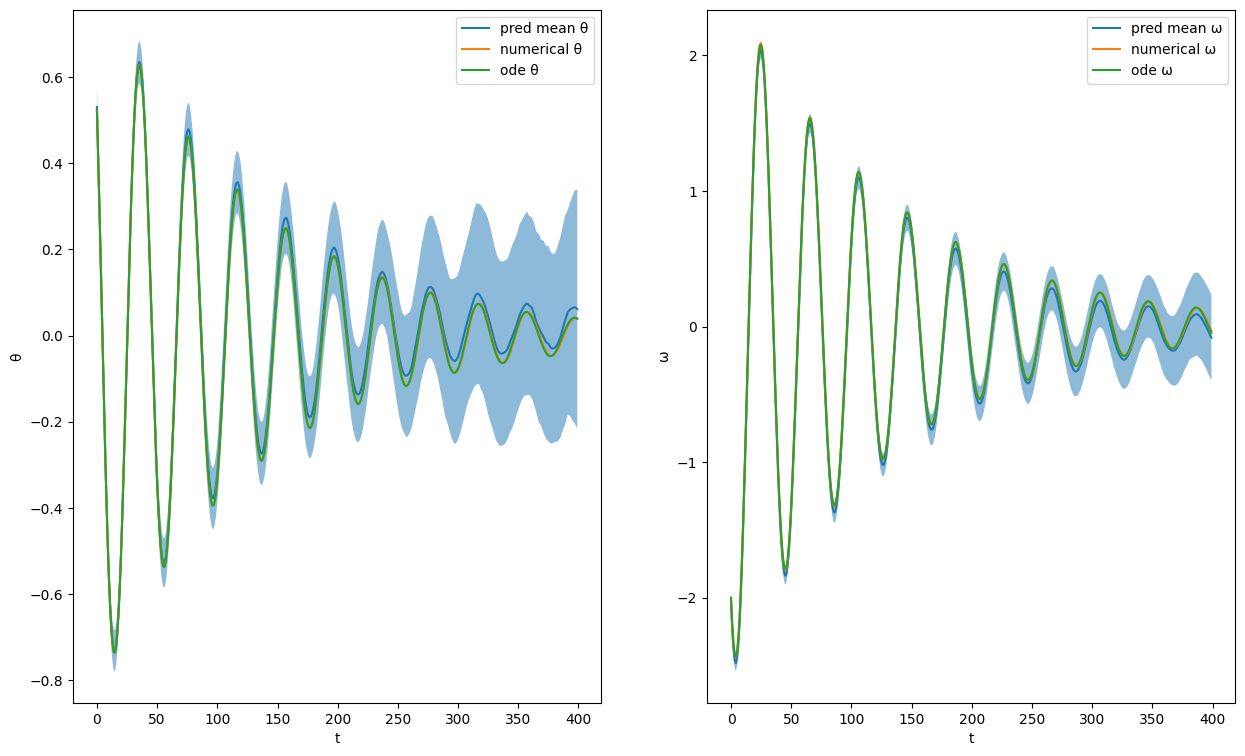

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
ax[0].set_xlabel("time")
ax[0].plot(mean_pred[:, 0], label="pred mean θ")
ax[0].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)
ax[0].plot(num_sol.ys[:, 0], label="numerical θ")
ax[0].plot(nn_sol[:, 0], label="ode θ")


ax[0].set_xlabel("t")
ax[0].set_ylabel("θ")
ax[0].legend()

# (ω,t)
ax[1].plot(mean_pred[:, 1], label="pred mean ω")
ax[1].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)
ax[1].plot(num_sol.ys[:, 1], label="numerical ω")
ax[1].plot(nn_sol[:, 1], label="ode ω")


ax[1].set_xlabel("t")
ax[1].set_ylabel("ω")
ax[1].legend()

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 120491 (\N{MATHEMATICAL BOLD CAPITAL DELTA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120491 (\N{MATHEMATICAL BOLD CAPITAL DELTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


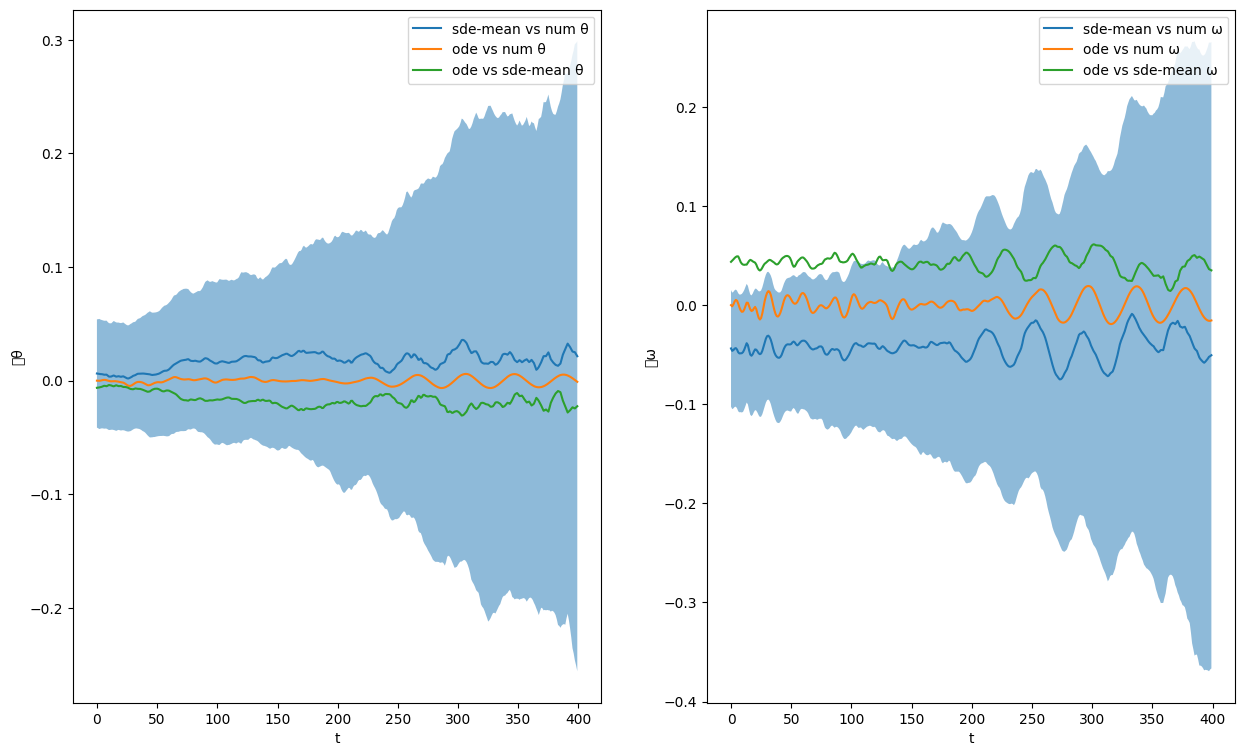

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
theta_res = mean_pred[:, 0] - num_sol.ys[:, 0]
ode_theta_res = nn_sol[:, 0] - num_sol.ys[:, 0]
ode_theta_mean = nn_sol[:, 0] - mean_pred[:, 0]

ax[0].set_xlabel("time")
ax[0].plot(theta_res, label="sde-mean vs num θ")
ax[0].plot(ode_theta_res, label="ode vs num θ")
ax[0].plot(ode_theta_mean, label="ode vs sde-mean θ")

ax[0].fill_between(jnp.arange(len(mean_pred)), theta_res - std_pred[:, 0], theta_res + std_pred[:, 0], alpha=0.5)

ax[0].set_xlabel("t")
ax[0].set_ylabel("𝚫θ")
ax[0].legend()

# (ω,t)

omega_res = mean_pred[:, 1] - num_sol.ys[:, 1]
ode_omega_res = nn_sol[:, 1] - num_sol.ys[:, 1]
ode_omega_mean = nn_sol[:, 1] - mean_pred[:, 1]

ax[1].plot(omega_res, label="sde-mean vs num ω")
ax[1].plot(ode_omega_res, label="ode vs num ω")
ax[1].plot(ode_omega_mean, label="ode vs sde-mean ω")

ax[1].fill_between(jnp.arange(len(mean_pred)), omega_res - std_pred[:, 1], omega_res + std_pred[:, 1], alpha=0.5)

ax[1].set_xlabel("t")
ax[1].set_ylabel("𝚫ω")
ax[1].legend()

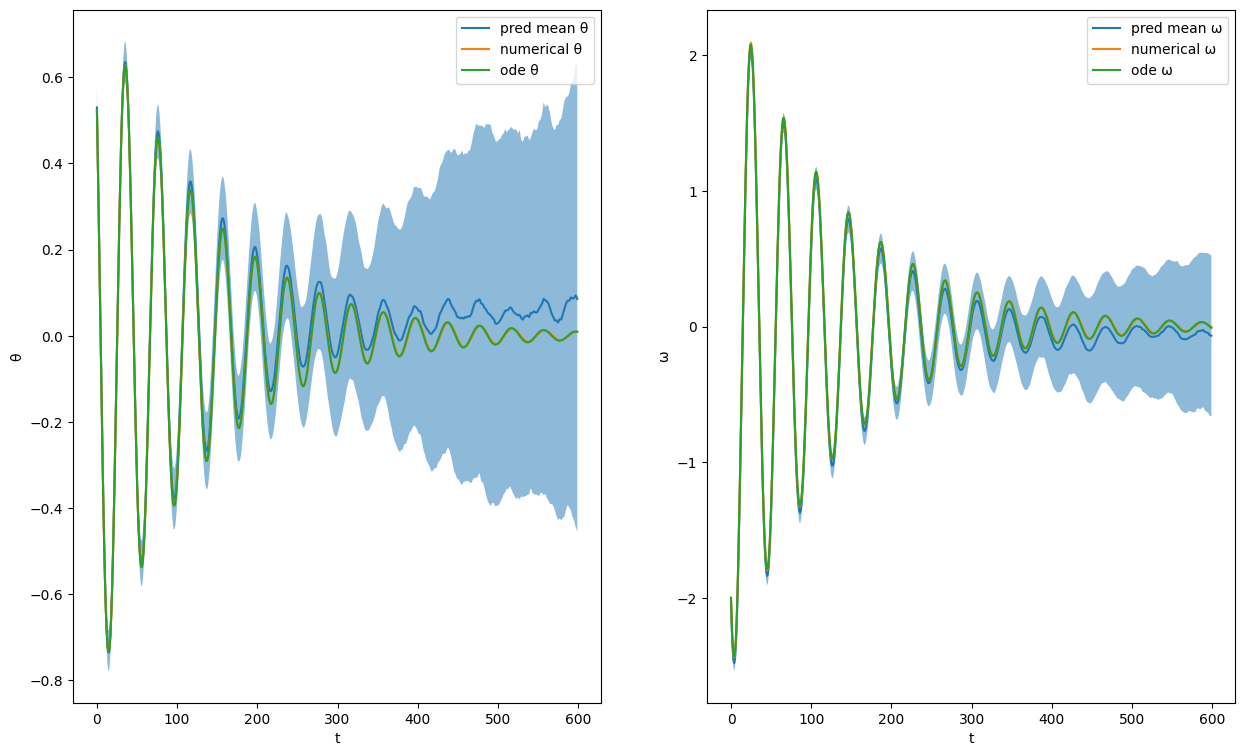

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
ax[0].set_xlabel("time")
ax[0].plot(mean_pred[:, 0], label="pred mean θ")
ax[0].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)
ax[0].plot(num_sol.ys[:, 0], label="numerical θ")
ax[0].plot(nn_sol[:, 0], label="ode θ")


ax[0].set_xlabel("t")
ax[0].set_ylabel("θ")
ax[0].legend()

# (ω,t)
ax[1].plot(mean_pred[:, 1], label="pred mean ω")
ax[1].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)
ax[1].plot(num_sol.ys[:, 1], label="numerical ω")
ax[1].plot(nn_sol[:, 1], label="ode ω")


ax[1].set_xlabel("t")
ax[1].set_ylabel("ω")
ax[1].legend()

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 120491 (\N{MATHEMATICAL BOLD CAPITAL DELTA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120491 (\N{MATHEMATICAL BOLD CAPITAL DELTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


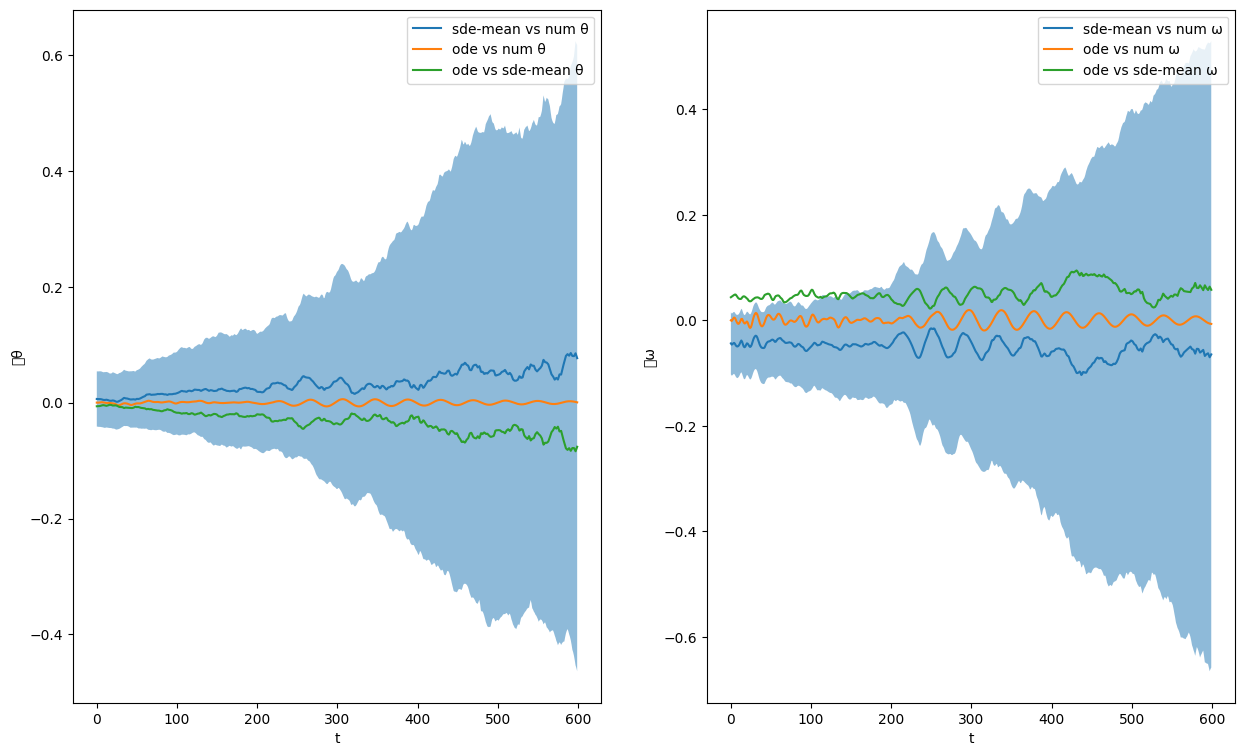

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
theta_res = mean_pred[:, 0] - num_sol.ys[:, 0]
ode_theta_res = nn_sol[:, 0] - num_sol.ys[:, 0]
ode_theta_mean = nn_sol[:, 0] - mean_pred[:, 0]

ax[0].set_xlabel("time")
ax[0].plot(theta_res, label="sde-mean vs num θ")
ax[0].plot(ode_theta_res, label="ode vs num θ")
ax[0].plot(ode_theta_mean, label="ode vs sde-mean θ")

ax[0].fill_between(jnp.arange(len(mean_pred)), theta_res - std_pred[:, 0], theta_res + std_pred[:, 0], alpha=0.5)

ax[0].set_xlabel("t")
ax[0].set_ylabel("𝚫θ")
ax[0].legend()

# (ω,t)

omega_res = mean_pred[:, 1] - num_sol.ys[:, 1]
ode_omega_res = nn_sol[:, 1] - num_sol.ys[:, 1]
ode_omega_mean = nn_sol[:, 1] - mean_pred[:, 1]

ax[1].plot(omega_res, label="sde-mean vs num ω")
ax[1].plot(ode_omega_res, label="ode vs num ω")
ax[1].plot(ode_omega_mean, label="ode vs sde-mean ω")

ax[1].fill_between(jnp.arange(len(mean_pred)), omega_res - std_pred[:, 1], omega_res + std_pred[:, 1], alpha=0.5)

ax[1].set_xlabel("t")
ax[1].set_ylabel("𝚫ω")
ax[1].legend()

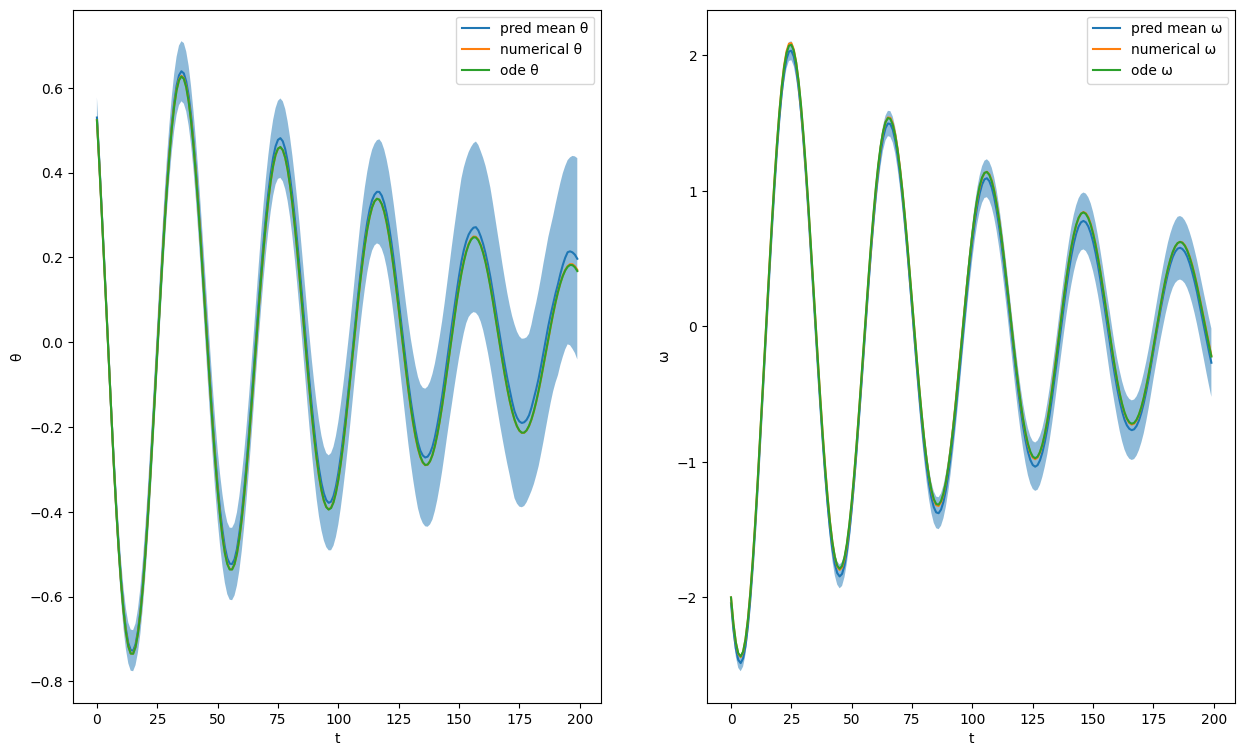

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
ax[0].set_xlabel("time")
ax[0].plot(mean_pred[:, 0], label="pred mean θ")
ax[0].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)
ax[0].plot(num_sol.ys[:, 0], label="numerical θ")
ax[0].plot(nn_sol[:, 0], label="ode θ")


ax[0].set_xlabel("t")
ax[0].set_ylabel("θ")
ax[0].legend()

# (ω,t)
ax[1].plot(mean_pred[:, 1], label="pred mean ω")
ax[1].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)
ax[1].plot(num_sol.ys[:, 1], label="numerical ω")
ax[1].plot(nn_sol[:, 1], label="ode ω")


ax[1].set_xlabel("t")
ax[1].set_ylabel("ω")
ax[1].legend()

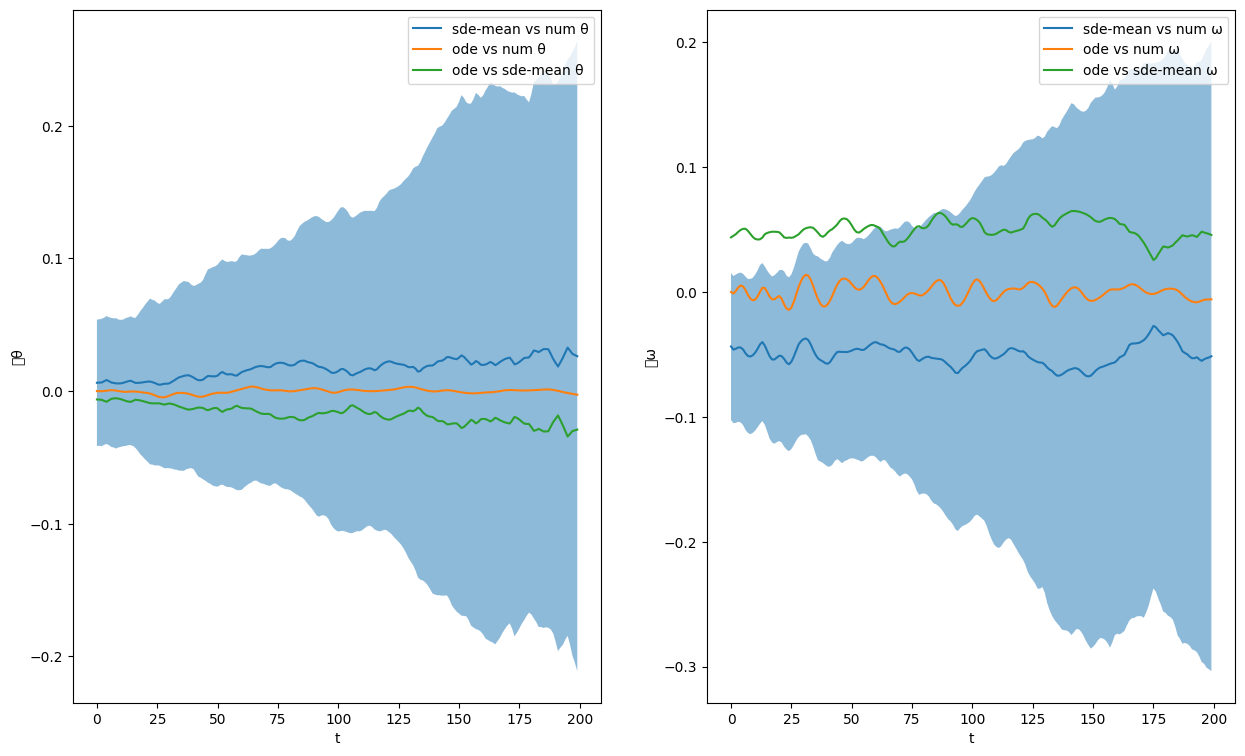

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
theta_res = mean_pred[:, 0] - num_sol.ys[:, 0]
ode_theta_res = nn_sol[:, 0] - num_sol.ys[:, 0]
ode_theta_mean = nn_sol[:, 0] - mean_pred[:, 0]

ax[0].set_xlabel("time")
ax[0].plot(theta_res, label="sde-mean vs num θ")
ax[0].plot(ode_theta_res, label="ode vs num θ")
ax[0].plot(ode_theta_mean, label="ode vs sde-mean θ")

ax[0].fill_between(jnp.arange(len(mean_pred)), theta_res - std_pred[:, 0], theta_res + std_pred[:, 0], alpha=0.5)

ax[0].set_xlabel("t")
ax[0].set_ylabel("𝚫θ")
ax[0].legend()

# (ω,t)

omega_res = mean_pred[:, 1] - num_sol.ys[:, 1]
ode_omega_res = nn_sol[:, 1] - num_sol.ys[:, 1]
ode_omega_mean = nn_sol[:, 1] - mean_pred[:, 1]

ax[1].plot(omega_res, label="sde-mean vs num ω")
ax[1].plot(ode_omega_res, label="ode vs num ω")
ax[1].plot(ode_omega_mean, label="ode vs sde-mean ω")

ax[1].fill_between(jnp.arange(len(mean_pred)), omega_res - std_pred[:, 1], omega_res + std_pred[:, 1], alpha=0.5)

ax[1].set_xlabel("t")
ax[1].set_ylabel("𝚫ω")
ax[1].legend()

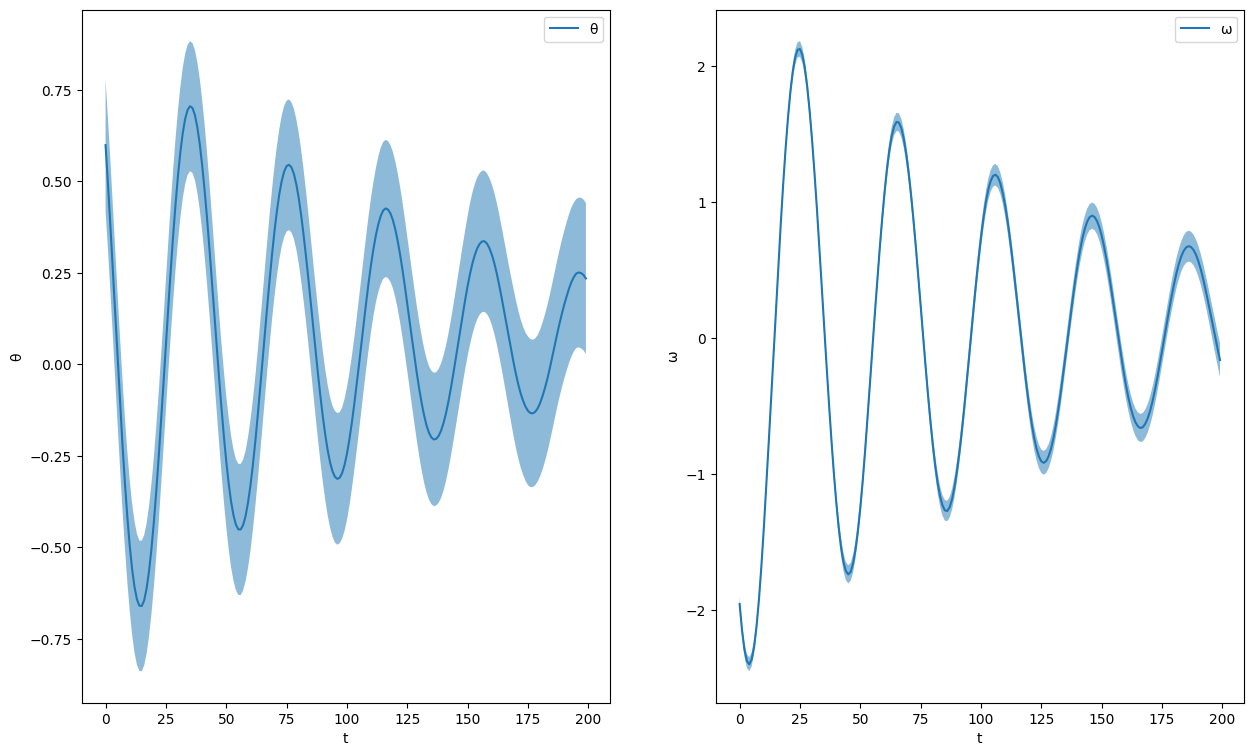

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
ax[0].set_xlabel("time")
ax[0].plot(mean_pred[:, 0], label="θ")
ax[0].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)
ax[0].set_xlabel("t")
ax[0].set_ylabel("θ")
ax[0].legend()

# (ω,t)
ax[1].plot(mean_pred[:, 1], label="ω")
ax[1].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)


ax[1].set_xlabel("t")
ax[1].set_ylabel("ω")
ax[1].legend()

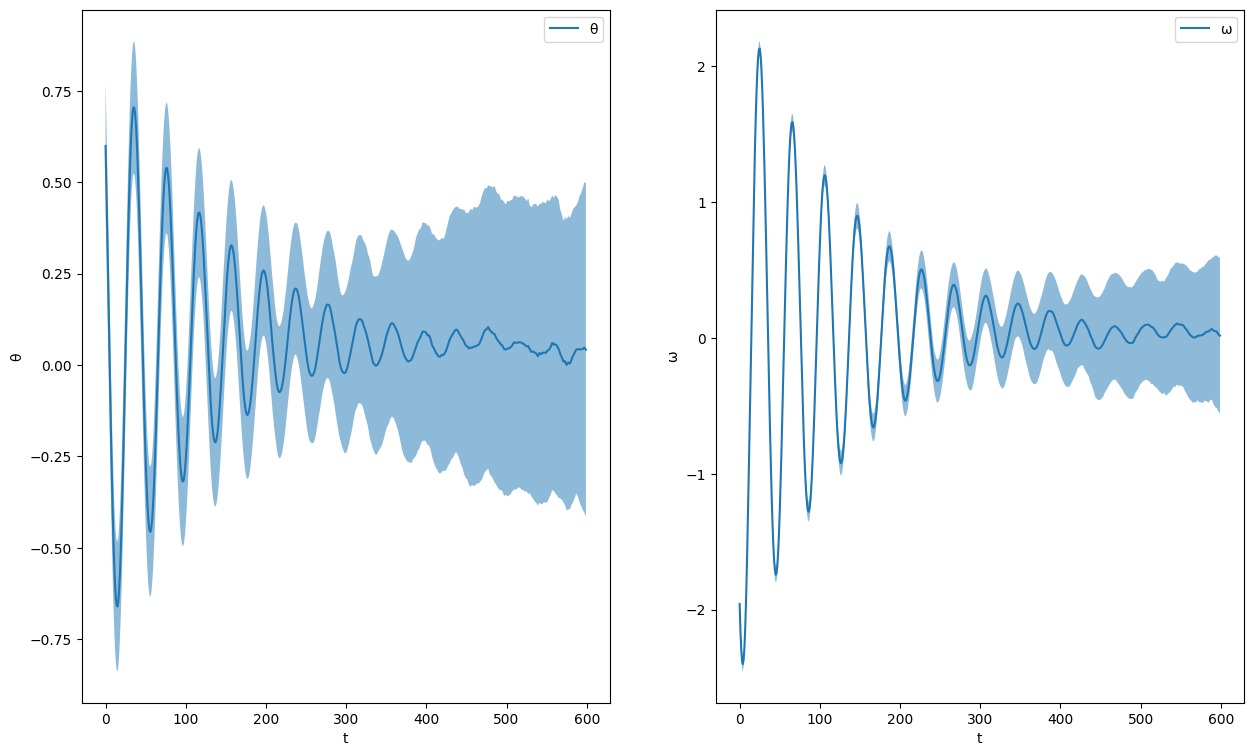

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
ax[0].set_xlabel("time")
ax[0].plot(mean_pred[:, 0], label="θ")
ax[0].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)
ax[0].set_xlabel("t")
ax[0].set_ylabel("θ")
ax[0].legend()

# (ω,t)
ax[1].plot(mean_pred[:, 1], label="ω")
ax[1].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)


ax[1].set_xlabel("t")
ax[1].set_ylabel("ω")
ax[1].legend()

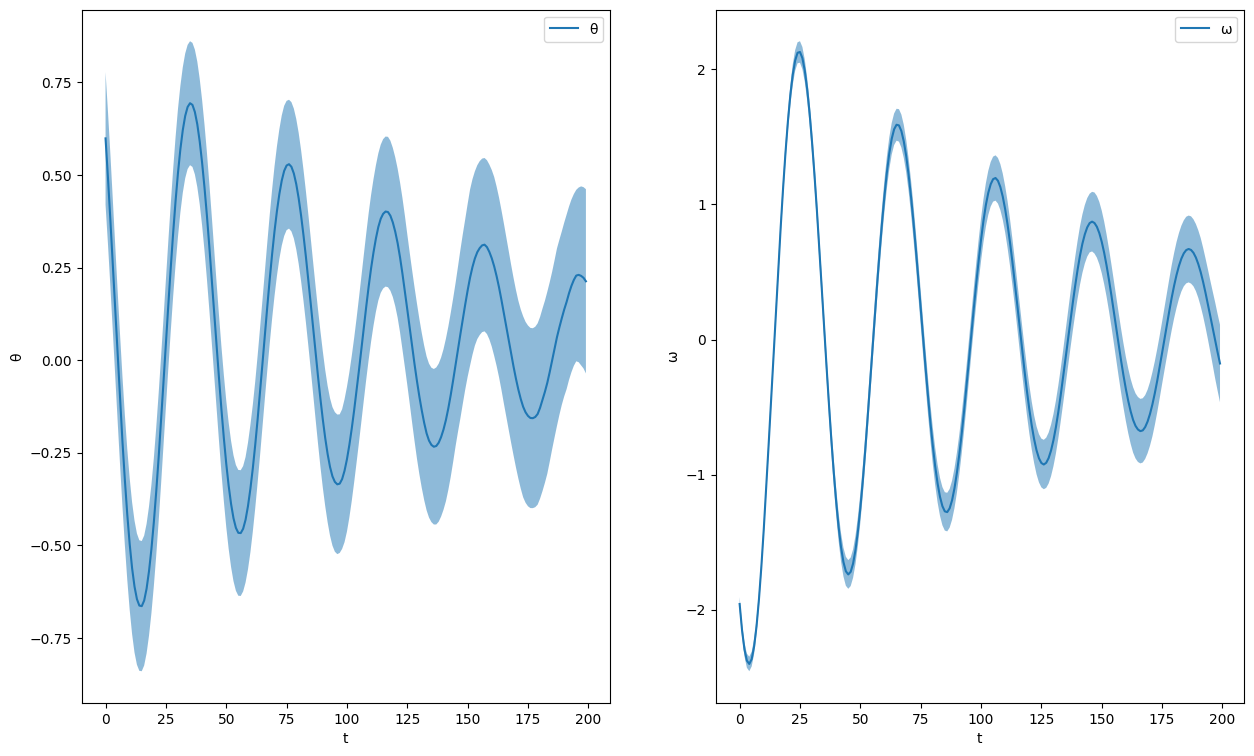

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

# (θ,t)
#ax[0,0].plot(ts_3, sol_4.ys[:,0], label="ODE θ")
ax[0].set_xlabel("time")
ax[0].plot(mean_pred[:, 0], label="θ")
ax[0].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 0] - std_pred[:, 0], mean_pred[:, 0] + std_pred[:, 0], alpha=0.5)
ax[0].set_xlabel("t")
ax[0].set_ylabel("θ")
ax[0].legend()

# (ω,t)
ax[1].plot(mean_pred[:, 1], label="ω")
ax[1].fill_between(jnp.arange(len(mean_pred)), mean_pred[:, 1] - std_pred[:, 1], mean_pred[:, 1] + std_pred[:, 1], alpha=0.5)


ax[1].set_xlabel("t")
ax[1].set_ylabel("ω")
ax[1].legend()